## Homework 6, Problem 2 on population vector and optimal linear estimator

ECE C143A/C243A, Spring Quarter 2022, Prof. J.C. Kao, TAs T. Monsoor and W. Yu

Total: 30 points.  In this notebook, you will implement an optimal linear estimator decoder.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import nsp as nsp
import pdb

matplotlib.style.use('dark_background')
# Load matplotlib images inline
%matplotlib inline
# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2
data = sio.loadmat('JR_2015-12-04_truncated2.mat') # load the .mat file.
R = data['R'][0,:]

### (a) (4 points) Tuning curve for one neuron

Fit a cosine tuning curve for electrode 17. On the same plot, plot the average firing rate for electrode 17 to each of the 8 directions and the fitted tuning curve.  The average firing rate should be computed in a window from [250, 500] ms after trial onset. Reach angle should be on the x-axis and firing rate on the y-axis. 

Hint: You may reuse code from HW #2 about tuning curve fitting to do this question.  We have provided two functions: calculateFR() and tuning() which ought simplify this question.  Take a look at what they do before calling them.  The function tuning returns the tuning curve of a neuron (i.e., the parameters of the tuning curve $c_0$, $c_1$, $\theta_0$ such that $f(\theta)= c_0+c_1 cos(\theta-\theta_0)$

In [2]:
def calculateFR(i, neuron_idx=16, window=[250,500]):
    # Calculates the firing rate of neuron_idx on trial i in the given window range.
    # Output units are spikes/s
    return float(len(R[i]['spikeRaster'][neuron_idx,window[0]:window[1]].todense().nonzero()[1])) / (window[1] - window[0]) * 1000

def tuning(thetas, meanFRs):
    # Calculates the parameters of a tuning curve.
    F = np.concatenate((np.ones((np.size(thetas), 1)),np.matrix(np.sin(thetas)).T,np.matrix(np.cos(thetas)).T),axis = 1)
    
    ks = np.linalg.pinv(F)*np.matrix(meanFRs).T
    c0 = ks[0]
    pd = np.arctan2(ks[1],ks[2])
    c1 = ks[1]/np.sin(pd)
    
    c0 = np.asarray(c0)[0][0]
    c1 = np.asarray(c1)[0][0]
    pd = np.asarray(pd)[0][0]
    return [c0,c1,pd]

c0=57.733883626115826
c1=22.662425288615186
theta0=1.4362465767565014 degrees


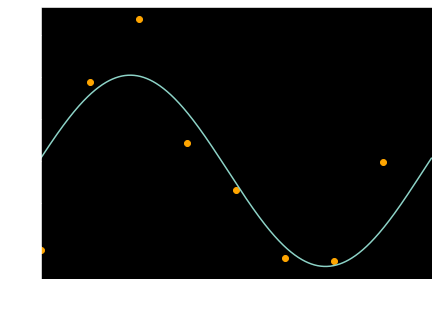

In [3]:
plt.figure(figsize=(7,5))

#====================================================#
# YOUR CODE HERE:
#   Fit the cosine tuning curve for electrode 17 and plot
#     1) the average firing rate for electrode 17 to each of the 8 directions and 
#     2) the fitted tuning curve.
#====================================================#
shapes=[]
for i in range(506):
    shapes.append(R[i]['spikeRaster'].todense().shape[1])


FRs=np.empty((R.shape[0]))
targets=np.empty((R.shape[0],2))
Theta=np.empty(R.shape[0])
for i in range(R.shape[0]):
    FRs[i]=calculateFR(i)
    targets[i,:]=[R[i]["target"][0,0],R[i]["target"][1,0]]
    Theta[i]=np.arctan2(R[i]["target"][1,0],R[i]["target"][0,0])
    

Theta=Theta*(Theta>0)+(Theta<0)*(2*np.pi+Theta)
# plt.plot(np.degrees(Theta),FRs,"o")


means=[]
for t in np.unique(Theta):
    plt.plot(np.degrees(t),np.mean(FRs[Theta==t]),"o",color="orange")
    means.append(np.mean(FRs[Theta==t]))
from sklearn.linear_model import LinearRegression



c0,c1,theta0=tuning(np.unique(Theta), means)
print(f"c0={c0}")
print(f"c1={c1}")
print(f"theta0={theta0} degrees")

plt.plot(np.degrees(np.arange(0,2*np.pi,0.01)),c0+c1*np.cos(np.arange(0,2*np.pi,0.01)-theta0))
#====================================================#
# END YOUR CODE
#====================================================#   



plt.xlabel('Reach angle')
plt.ylabel('Firing rate')
plt.xlim([0,360])
plt.show()

In [4]:
R[i]['spikeRaster'].todense().shape

(96, 1033)

### (b) (4 points) Preferred direction and modulation depth

Calculate the tuning parameters for every electrode. Pick the top 30 electrodes having the largest values of $|c_1|$ (where $c_1$, from homework #2, is from the tuning curve expression $\theta_0$ such that $f(\theta)= c_0+c_1 cos(\theta-\theta_0)$. The larger $|c_1|$, the greater the "modulation depth" of the electrode.  This modulation depth is defined as the difference in firing rate between the preferred and anti-preferred directions. For each of these top 30 electrodes, plot the preferred direction in polar coordinates. The magnitude of each vector should be $|c_1|$. Do these top 30 neurons span the reaching space well?

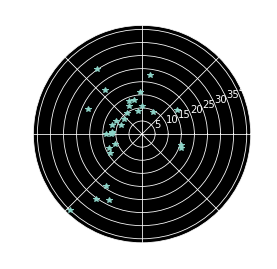

In [5]:
#====================================================#
# YOUR CODE HERE:
#   Generate a polar plot for the top 30 electrodes where 
#   the angle is the preferred direction of a neuron and 
#   its magnitude is |c1|.
#
#   Hint: call plt.polar(top_30_angles, top_30_c1, '*')
#====================================================#
FRs=np.empty((R.shape[0],96))
Theta=np.empty(R.shape[0])
for i in range(R.shape[0]):
    for j in range(96):
        FRs[i,j]=calculateFR(i,neuron_idx=j)
    Theta[i]=np.arctan2(R[i]["target"][1,0],R[i]["target"][0,0])
    
    
C0s=np.empty(96)
C1s=np.empty(96)
Theta0s=np.empty(96)
for i in range(96):
    means=[]
    for t in np.unique(Theta):
        means.append(np.mean(FRs[Theta==t,i]))
        
    c0,c1,theta0=tuning(np.unique(Theta), means)
    
    C0s[i]=c0
    C1s[i]=c1
    Theta0s[i]=theta0
    
TopInds = np.argpartition(C1s, -30)[-30:]

plt.polar(Theta0s[TopInds], C1s[TopInds], '*')


#====================================================#
# END YOUR CODE
#====================================================# 

Question:  Do these top 30 neurons span the reaching space well?

Answer: No, for instance there are no neurons at around the 270 degree location

### (c) (4 points) Preparing kinematics for optimal linear estimator. [Code solution provided; please understand it and answer the question.]

Fit the preferred directions by building an optimal linear estimator. We’ll use the first 400 trials in the R-struct for training and reserve the last 106 trials for testing our decoder in part (g). Concatenate all the neural data, at 1 ms resolution <br>
(hint: use the command `Y = scipy.sparse.hstack(R[0:400]['spikeRaster'])`).

Next, bin the millisecond resolution neural data, Y (representing the concatenated millisecond activity across the 400 trials), by counting the spikes in non-overlapping 25 ms bins. (Hint: use the `nsp.bin` function we provided.) 

To be clear, each row, corresponding to one electrode of neural data, should be binned in non-overlapping 25 ms bins. Name this variable `Y_bin`. Append a row of 1’s at the bottom of `Y_bin` via:
`Y_bin= np.vstack((Y_bin,np.ones(np.size(Y_bin,1))))`
to allow a bias term to be fit. 

Similarly, calculate the corresponding hand velocities in 25 ms intervals by using a first order Euler approximation, i.e.,

$$v(t) = \frac{cursorPos[t+25] -cursorPos[t]}{0.025}$$
(Hint: Like the neural data, concatenate all the cursor positions, at 1 ms resolution, by using the command `X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])`, then sample these velocities every 25 ms, and call the resultant matrix of velocities `X_bin`. Discard the last bin that does not have 25 ms worth of data.). 

Note that if you have done everything correctly, then `np.size(Y_bin, 1)` should equal `np.size(X_bin, 1)`. What are the dimensions of `Y_bin` and `X_bin`?

(Aside: If you observe the velocities, you’ll notice that they are not as smooth as they could be; this could be improved by using higher-order approximations to compute velocity – however, we wanted to keep the velocity calculation simple in this homework.)

In [6]:
#====================================================#
# YOUR CODE HERE:
#   Bin the data.
#====================================================#
dt = 25
binnedR = np.empty((0,0),dtype = list)
train_num = 400
Y = scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
print(Y.shape)
X = scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X = scipy.sparse.csc_matrix(X)
Y_bin = nsp.bin(Y, dt,'sum')
Y_bin = np.vstack((Y_bin, np.ones(np.size(Y_bin,1))))

X_bin = nsp.bin(X, dt,'first')
X_bin = np.diff(X_bin[0:2,:])/dt*1000
#====================================================#
# END YOUR CODE
#====================================================# 

(96, 411626)


In [7]:
X_bin

array([[-18.000000000000114, -54.39999999999998, -39.19999999999959, ...,
        -0.3999999999999915, 0.3999999999999915, 0.0],
       [-8.799999999999955, -31.200000000000045, -24.800000000000182,
        ..., -17.200000000000273, -9.19999999999959, -17.600000000000477]],
      dtype=object)

In [8]:
print("size of Y_bin:", Y_bin.shape)
print("size of X_bin:", X_bin.shape)

size of Y_bin: (97, 16465)
size of X_bin: (2, 16465)


Question: What are the dimensions of `Y_bin` and `X_bin`?

Answer:

```size of Y_bin: (97, 16465)```

```size of X_bin: (2, 16465)```

### (d) (6 points) Fitting the parameters in an OLE

Fit the optimal linear estimator that takes your spike counts binned at 25 ms resolution, `Y_bin`, and your sampled velocities every 25 ms, `X_bin`, and calculates the optimal linear decoder via:

$$ L = X_{bin} * Y_{bin}^{\dagger}$$
where $Y_{bin}^{\dagger}$ is the pseudo inverse of $Y_{bin}$, you can use `scipy.linalg.pinv` in python to calculate the pseudo inverse.<br>
Consider the top 30 electrodes in part (b). For each of these 30 electrodes, we want to visualize their preferred direction and modulation depth (like we did for the cosine fits of preferred direction). If electrode $i$ is one of these 30 electrodes, plot `L[:, i]` in polar coordinates. (Think about why we can think of `L[:,i]` as a preferred direction and magnitude.)  Does this plot look similar to the plot you derived in part (b)?

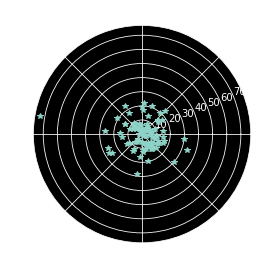

In [9]:
#====================================================#
# YOUR CODE HERE:
#   Fit the OLE matrix L via least squares, and visualize
#   L[:,i] for the top 30 electrodes found in part (b) in
#   an analogous polar plot.
#====================================================#
Y_bin=Y_bin.astype(float)
L=np.matmul(X_bin,scipy.linalg.pinv(Y_bin))
r=[]
theta=[]
for i in range(L.shape[1]):
    theta.append( np.arctan2(L[0,i],L[1,i]))
    r.append(np.sqrt(L[0,i]**2+L[1,i]**2))
plt.polar(theta,r, '*')

#====================================================#
# END YOUR CODE
#====================================================#

Question: Does this plot have better coverage of the entire workspace than the plot you derived in part (b)?

Abswer: yes

### (e) (6 points) 

Using the matrix $L$ you derived in part (d), we will now decode new neural data. Using the last 106 trials, we’ll evaluate how good our optimal linear estimator is. We are going to operate trial by trial. For each trial in the R-struct, bin the neural data at 25 ms resolution. Remember to append a row of 1’s at the bottom of the neural data. Use the matrix $L$ to decode the neural activity and get decoded velocities for each trial. On the same plot, show the decoded trajectory for each trial. Use `R[i]['cursorPos'][0:2,0]` as the starting cursor position on trial $i$, and find position by integrating the decoded velocity. Do the trajectories appear normal, or are there idiosyncracies in the decoder?

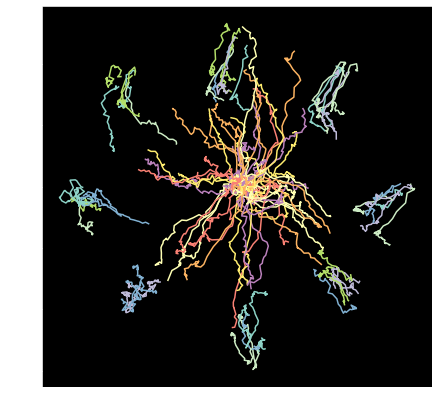

In [10]:
plt.figure(figsize=(7,7))
#====================================================#
# YOUR CODE HERE:
#   Decode data for the last 106 trials, and plot the 
#   decoded positions.  If pos is a 2 x T array holding
#   all the decoded positions, you may plot them via:
#
#     plt.plot(pos[0,:], pos[1,:], '.')
#
#====================================================#

for i in range(106):
    Y_test = R[train_num+i]['spikeRaster']
    Y_bin_test=nsp.bin(Y_test, dt,'sum').astype('float64')
    Y_bin_test=np.vstack((Y_bin_test, np.ones(np.size(Y_bin_test,1))))

    predV=np.matmul(L,Y_bin_test)
    #print(R[train_num+i]['cursorPos'][0:2,0])
    predLoc=(np.cumsum(predV,axis=1).T*25/1000+R[train_num+i]['cursorPos'][0:2,0]).T
    plt.plot(predLoc[0,:],predLoc[1,:])
    # plt.plot(R[train_num+i]['cursorPos'][0,:],R[train_num+i]['cursorPos'][1,:],'--')
    # plt.plot(R[train_num+i]['cursorPos'][0,0],R[train_num+i]['cursorPos'][1,0],'o',color="red")

#====================================================#
# END YOUR CODE
#====================================================#

Question: Do the trajectories appear normal, or are there idiosyncracies in the decoder?

Answer: 
There seems to be idiosyncracies in the decoder, the lines seem to be squilely and are note able to fully connect the two nodes

### (f) (3 points) 

For the decoder in part (e), what is the average mean-square error in position per trial? (For each time bin in a trial, calculate the squared Euclidean distance between the decoded position and the true hand position. Average all these squared Euclidean distance differences across all time in the trial. Finally, average across all trials.)

In [41]:
#====================================================#
# YOUR CODE HERE:
#   Calculate the mean-squared error between the decoded
#   hand position and the true hand position.  Average
#   the squared errors across time; then average the squared
#   errors across trials.
#====================================================#
sum_distance=0
for i in range(106):
    Y_test = R[train_num+i]['spikeRaster']
    Y_bin_test=nsp.bin(Y_test, dt,'sum').astype('float64')
    Y_bin_test=np.vstack((Y_bin_test, np.ones(np.size(Y_bin_test,1))))

    predV=np.matmul(L,Y_bin_test)
    #print(R[train_num+i]['cursorPos'][0:2,0])
    predLoc=(np.cumsum(predV,axis=1).T*dt/1000+R[train_num+i]['cursorPos'][0:2,0]).T
    t=np.arange(0,predLoc.shape[1]*dt,dt)+dt-1

    distance=(R[train_num+i]['cursorPos'][:2,t]-predLoc).astype(float)
    distance=np.sqrt(np.sum(distance**2,axis=0))
    sum_distance+=np.mean(distance)

print(sum_distance/106)
#====================================================#
# END YOUR CODE
#====================================================#

61.00432010581678


Answer: 61.00432010581678